# Trabajo práctico integrador: Machine learning II

Especialización en IA - FIUBA
3er bimestre 2022

Integrantes:
* Carlos Massobrio
* Lionel Gutierrez 
* Benjamin Tourn

## Introducción y motivación

Tomando el dataset de ["Water potability"]( https://www.kaggle.com/datasets/adityakadiwal/water-potability) de kaggle, el presente trabajo tiene el objetivo de detectar si el agua es potable (apta para el consumo humano) evaluando las siguientes características:

*   PH: evalua el balance del ácido-base del agua. También es el indicador de la condición ácida o alcalina del estado del agua.
*   Hardness (dureza): es principamente causado por las sales de calcio y magnesio.
*   Solids (Total dissolved solids - TDS) (sólidos): son los minerales disueltos en la misma, que producen un sabor no deseado y un color diluido en la apariencia del agua. Un valor alto indica agua muy mineralizada.
*   Chloramines (cloramina): son sustancias desinfectantes utilizados en los sistemas públicos de agua. 
*   Sulfate (sulfato): son sustancias naturales que se utilizan en la industria química.
*   Conductivity (conductividad): el agua de por si es un aislante, pero los iones de minerales la hacen más conductora.
*   Organic_carbon (carbono orgánico): proviene de materiales en descomposición y de fuentes sintéticas.
*   Trihalomethanes (Trihalometano): son sustancias químicas que se pueden encontrar en el agua tratada con cloro. Su nivel varia con la cantidad de cloro y materia orgánica en el agua.
*   Turbidity (Turbidez): depende de la cantidad de materia sólida presente en estado de suspensión.

Nuestro dataset contiene métricas de calidad del agua para 3276 cuerpos de agua diferentes.

Resolveremos un problema de aprendizaje supervisado de clasificación.

##Preparación del entorno de trabajo

Se instalan e inicializan las bibliotecas necesarias para el análisis y generación de los modelos y algoritmos. También se monta el google Drive para importar los datasets desde el mismo.

In [ ]:
%reset -f

In [ ]:
# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Preprocesamiento
from sklearn.impute import KNNImputer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.preprocessing import power_transform, PowerTransformer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.compose import make_column_transformer

# Preparación del set de datos
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import StratifiedKFold, KFold

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans


# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbpipeline


# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Evaluación de modelos
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score 

from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Semillas
seed = np.random.seed(22)
rng = np.random.RandomState(1)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))


Pandas:1.3.5
Numpy:1.21.6
Matplotlib:3.2.2
SKlearn:1.0.2
Seaborn:0.11.2



## Cargamos el dataset desde el google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH='/content/drive/MyDrive/Colab Notebooks/data'

water_data = pd.read_csv(DATASET_PATH+"/water_potability.csv",delimiter=',')

## Analisis de datos

### Análisis introductorio

####Observamos cantidad de filas y columnas del dataset

In [ ]:
print("Cantidad de muestras(filas) del dataset:",water_data.shape[0])
print("Cantidad de features(columnas) del dataset:",water_data.shape[1])

Cantidad de muestras(filas) del dataset: 3276
Cantidad de features(columnas) del dataset: 10


####Imprimimos las primeras filas del dataset

In [ ]:
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


####Imprimimos las últimas filas del dataset

In [ ]:
water_data.tail()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1
3275,7.874671,195.102299,17404.177061,7.509306,NaN,327.459760,16.140368,78.698446,2.309149,1


####Imprimimos los tipos de dato y la cantidad de datos no nulos de cada columna del dataset

In [ ]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


####Describimos cada columna con estadisticas básicas

In [ ]:
water_data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


####Analizamos la cantidad de NaNs

In [ ]:
nans = water_data.loc[water_data.isna().sum(axis=1) >= 1, :]
print('Cantidad de filas con nans {}'.format(nans.shape[0]))

not_nans = water_data.loc[water_data.isna().sum(axis=1) == 0, :]
print('Cantidad de filas sin nans {}'.format(not_nans.shape[0]))

Cantidad de filas con nans 1265
Cantidad de filas sin nans 2011


In [ ]:
water_data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

### Análisis detallado de las features: histograma, box-plot y QQ-plot.

####Definimos las funciones para graficar y analizar los datos

In [ ]:
#Función que hace los 3 gráficos histograma, box-plot y QQ-plot.
def outlier_diagnostic_plots(df, variable):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    # Histograma
    sns.histplot(df[variable], bins=30,ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    # QQ-plot
    stats.probplot(df[df[variable].notnull()][variable], dist="norm", fit=True, plot=axes[1])
    axes[1].set_title('QQ')
    
    # Box-plot    
    sns.boxplot(y=df[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

In [ ]:
#Función que determina el límite mínimo y máximo en donde los valores
#no se conviernte en otuliers.
def find_normal_boundaries(df, variable):
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()
    return upper_boundary, lower_boundary

#### 1- Analisis feature ph




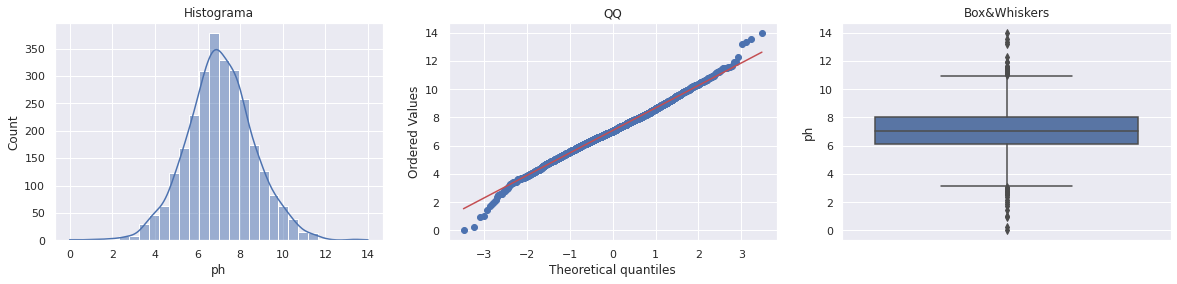

In [ ]:
outlier_diagnostic_plots(water_data, 'ph')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'ph')
upper_boundary, lower_boundary

(11.863753060403255, 2.297835948150383)

##### 1.1- Analisis para potability=0

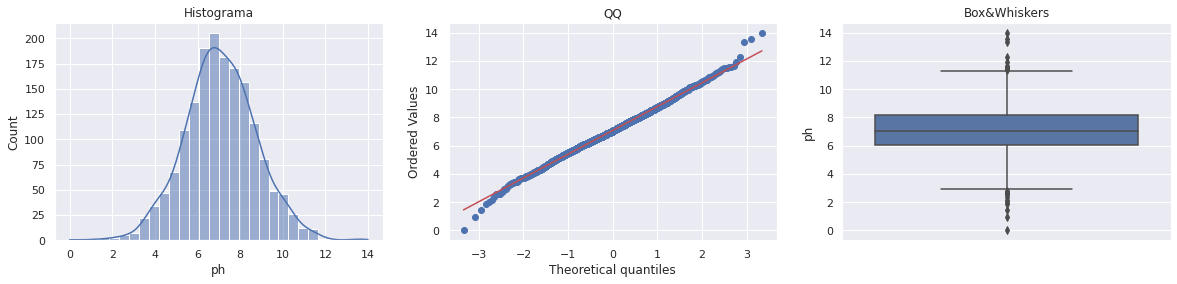

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'ph')

##### 1.2- Analisis para potability=1

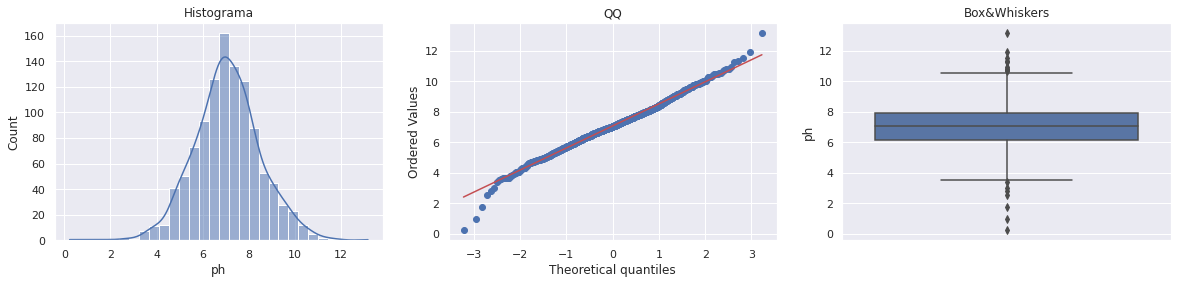

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'ph')

Las ditribuciones tanto para el caso de potable y no potable son similares.

#### 2- Analisis feature Hardness

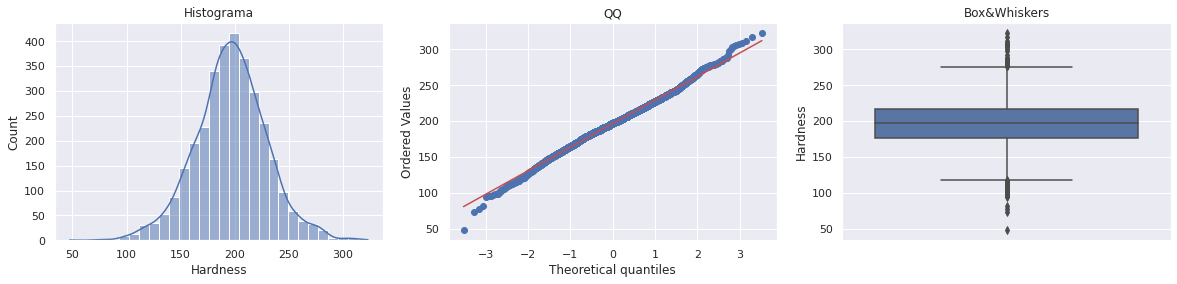

In [ ]:
outlier_diagnostic_plots(water_data, 'Hardness')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Hardness')
upper_boundary, lower_boundary

(295.00878044618435, 97.73021158841922)

##### 2.1- Analisis para potability=0

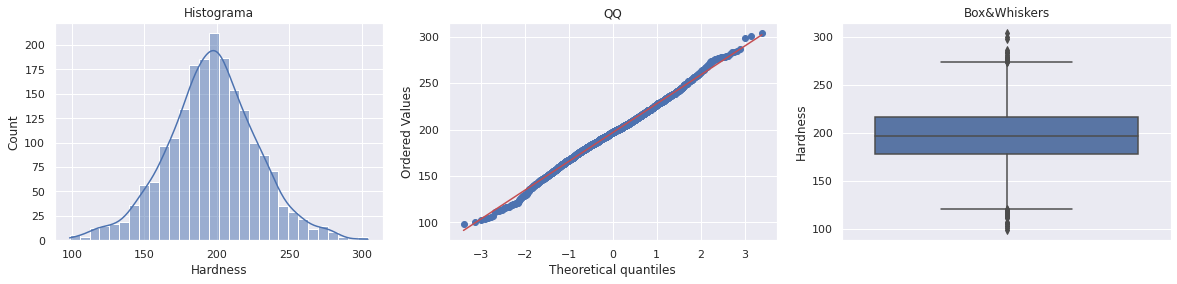

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Hardness')

##### 2.2- Analisis para potability=1

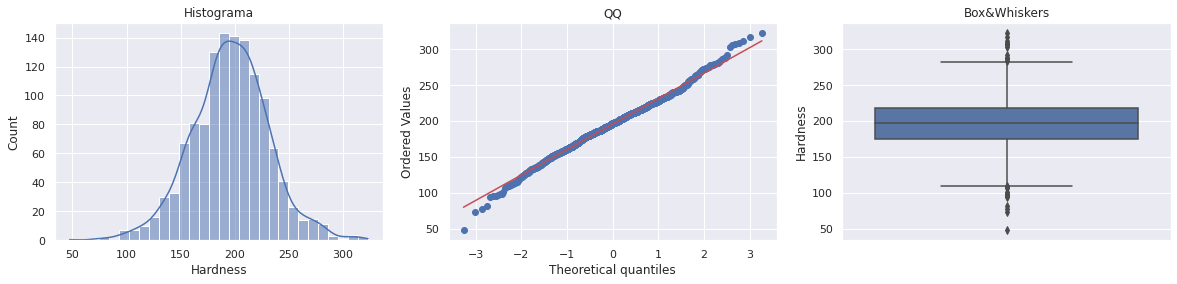

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Hardness')

#### 3- Analisis feature Solids

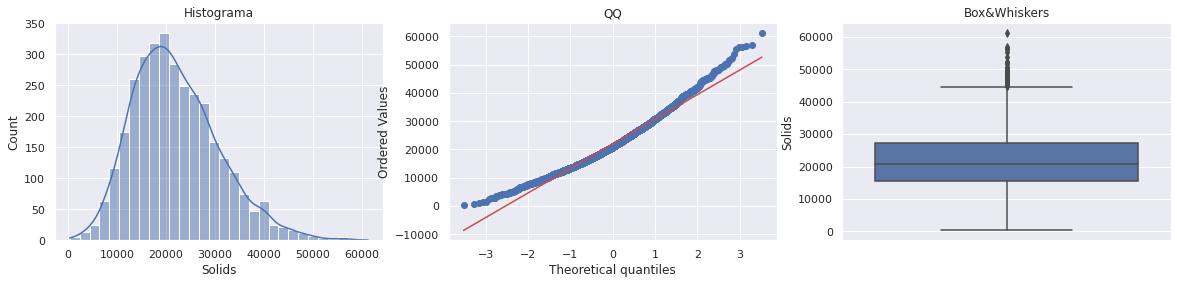

In [ ]:
outlier_diagnostic_plots(water_data, 'Solids')#Llevar a una normal.

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Solids')
upper_boundary, lower_boundary

(48319.80500943491, -4291.619957280687)

##### 3.1- Analisis para potability=0

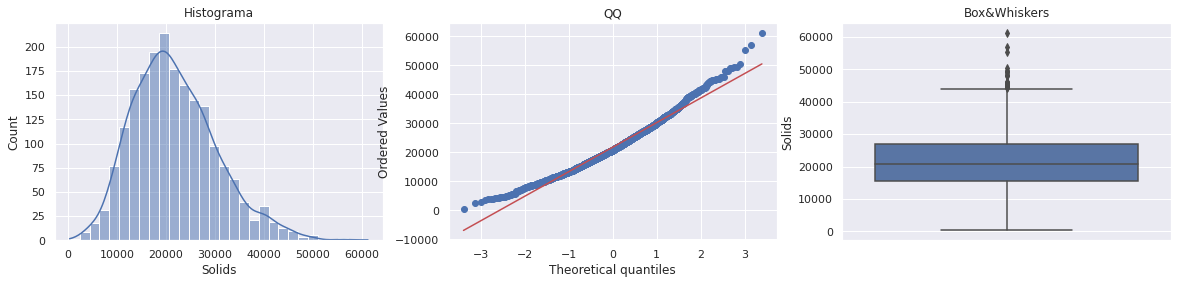

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Solids')

##### 3.2- Analisis para potability=1

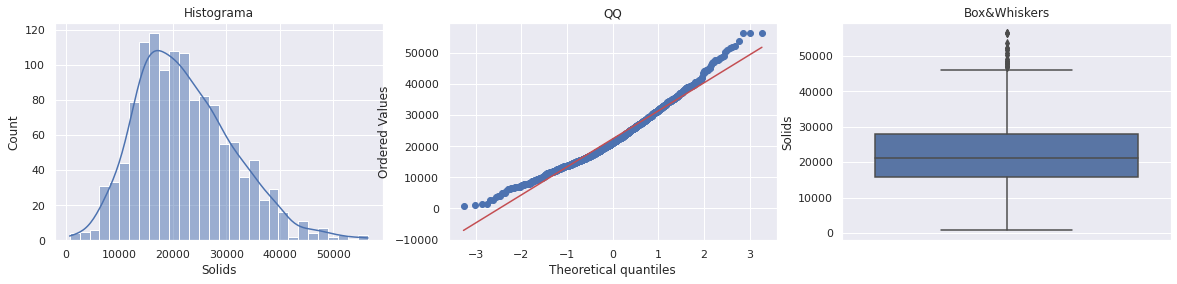

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Solids')

#### 4- Analisis feature Chloramines

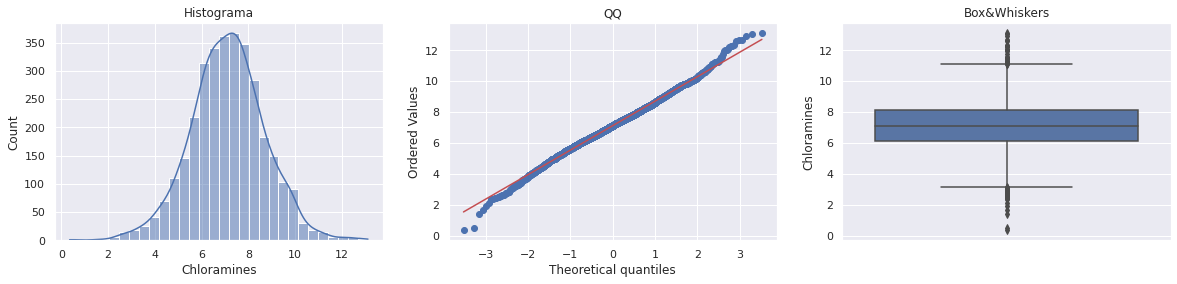

In [ ]:
outlier_diagnostic_plots(water_data, 'Chloramines')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Chloramines')
upper_boundary, lower_boundary

(11.871531460544917, 2.3730221263066564)

##### 4.1- Analisis para potability=0

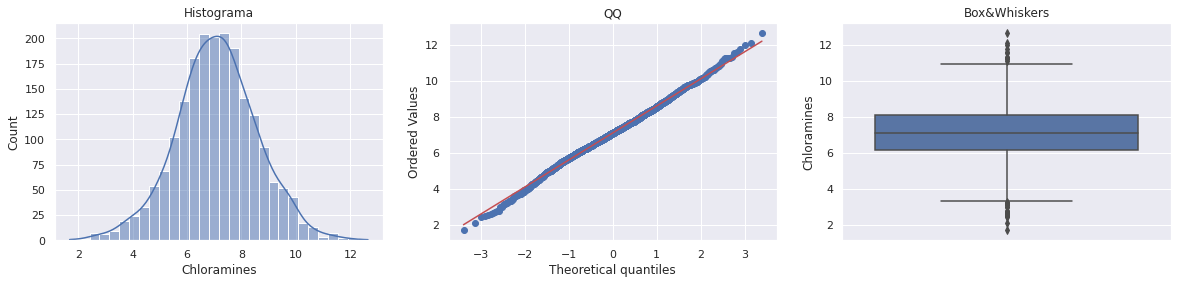

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Chloramines')

##### 4.2- Analisis para potability=1

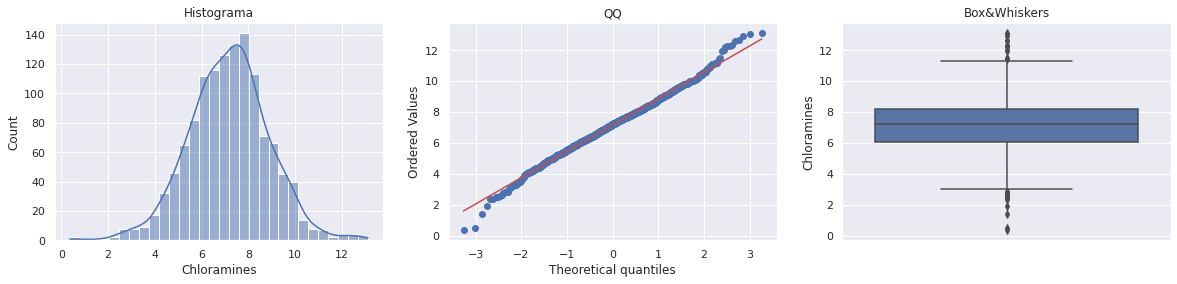

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Chloramines')

#### 5- Analisis feature Sulfate

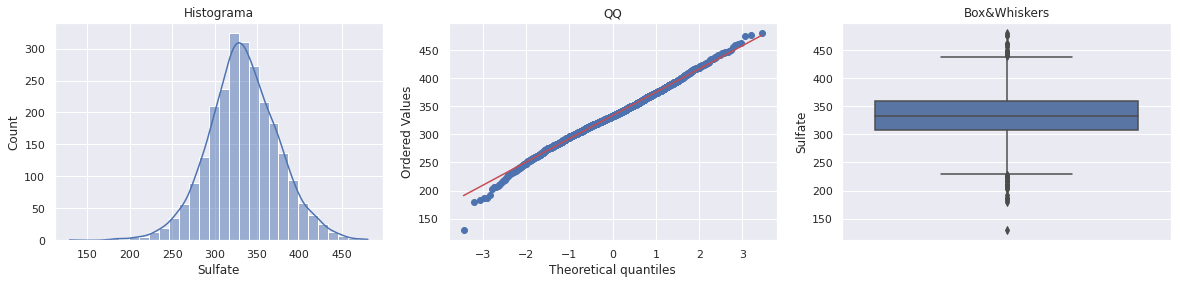

In [ ]:
outlier_diagnostic_plots(water_data, 'Sulfate')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Sulfate')
upper_boundary, lower_boundary

(458.02629799583144, 209.52525522579535)

##### 5.1- Analisis para potability=0

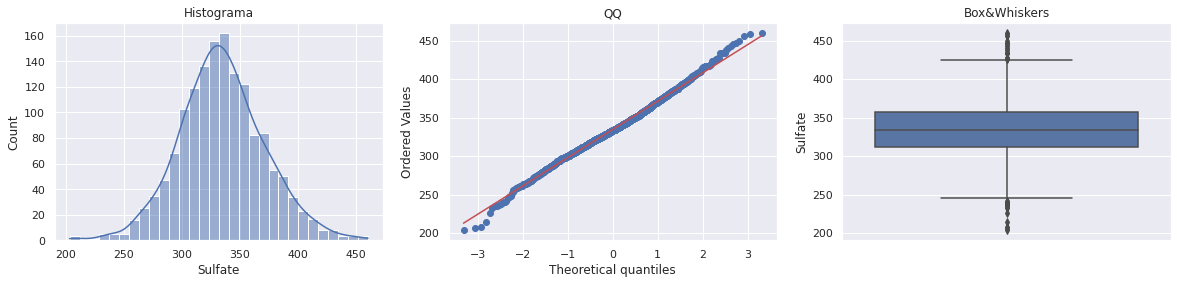

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Sulfate')

##### 5.2- Analisis para potability=1

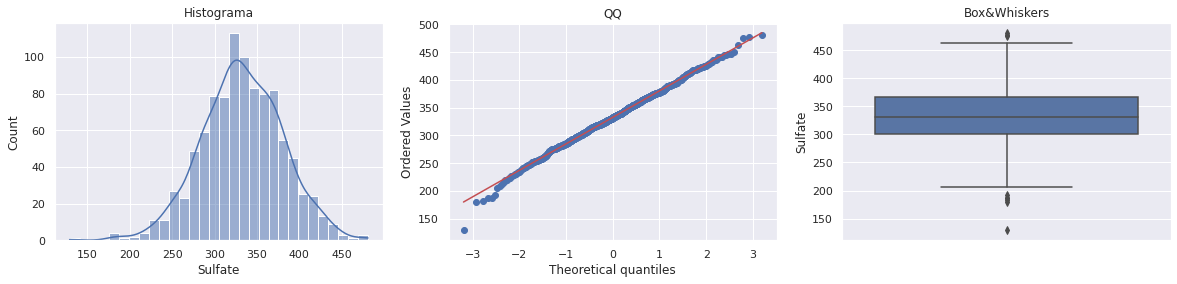

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Sulfate')

#### 6- Analisis feature Conductivity

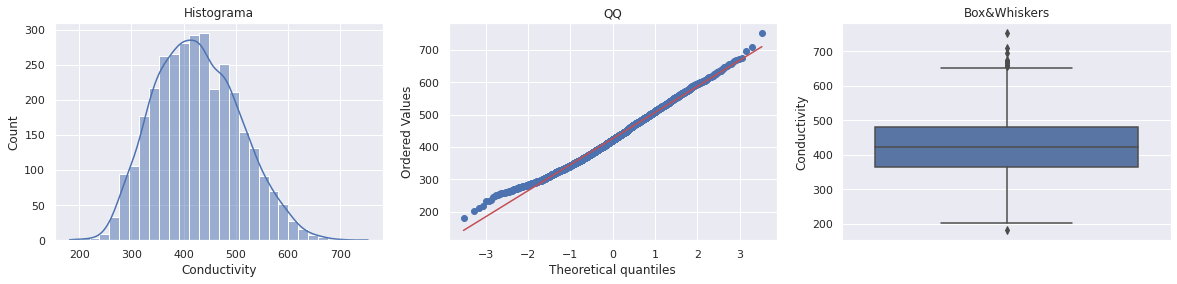

In [ ]:
outlier_diagnostic_plots(water_data, 'Conductivity')#Llevar a una normal.

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Conductivity')
upper_boundary, lower_boundary

(668.6773028358875, 183.73291852921665)

##### 6.1- Analisis para potability=0

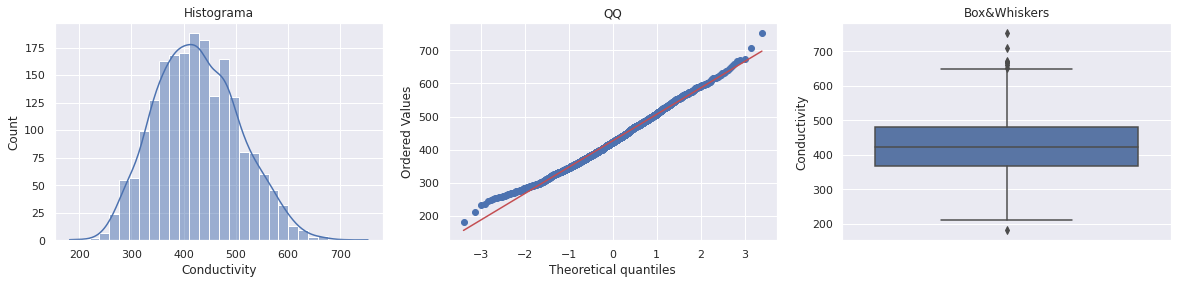

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Conductivity')

##### 6.2- Analisis para potability=1

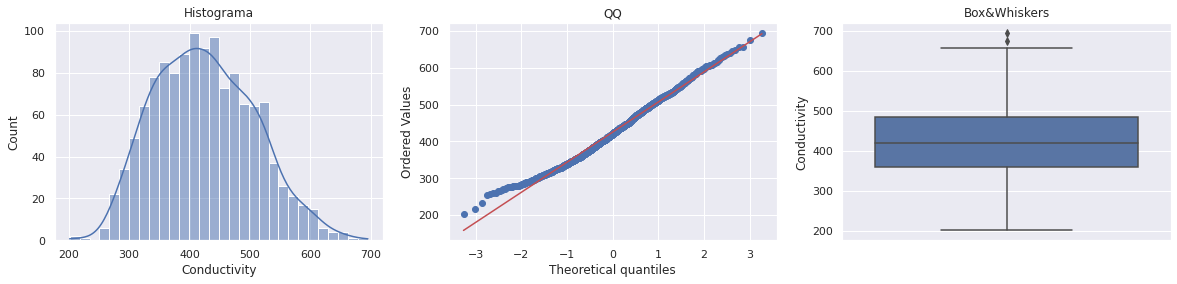

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Conductivity')

#### 7- Analisis feature organic_carbon

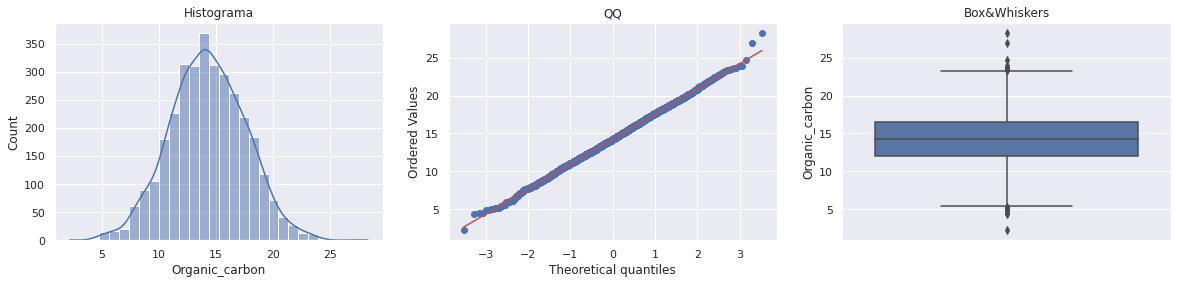

In [ ]:
outlier_diagnostic_plots(water_data, 'Organic_carbon')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Organic_carbon')
upper_boundary, lower_boundary

(24.20945624505794, 4.360484250296732)

##### 7.1- Analisis para potability=0

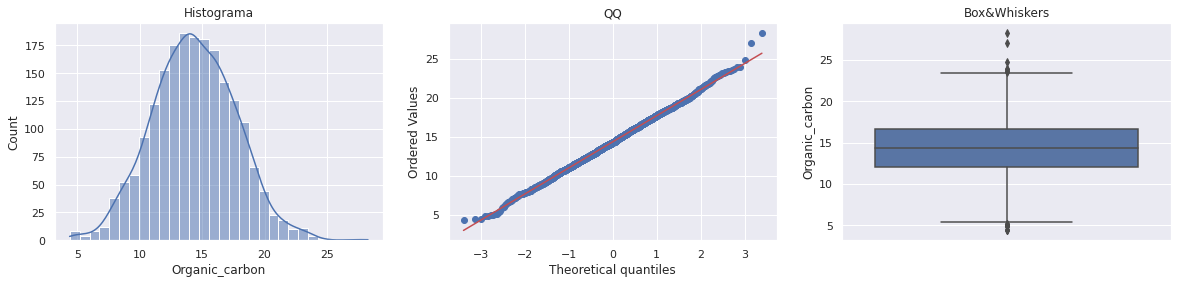

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Organic_carbon')

##### 7.2- Analisis para potability=1

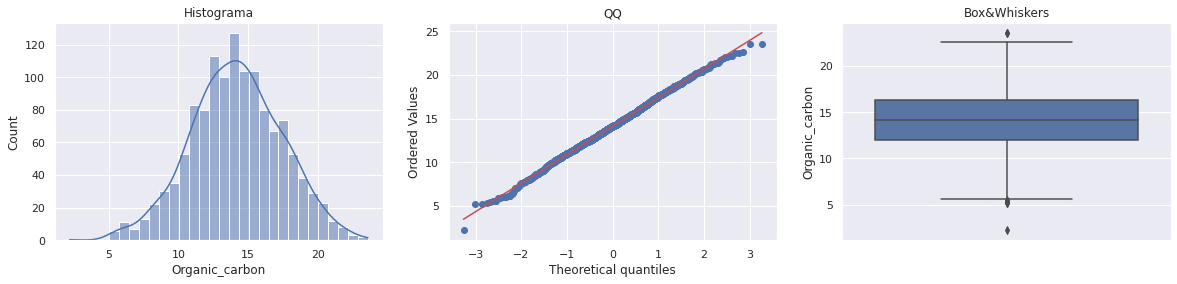

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Organic_carbon')

#### 8- Analisis feature Trihalomethanes

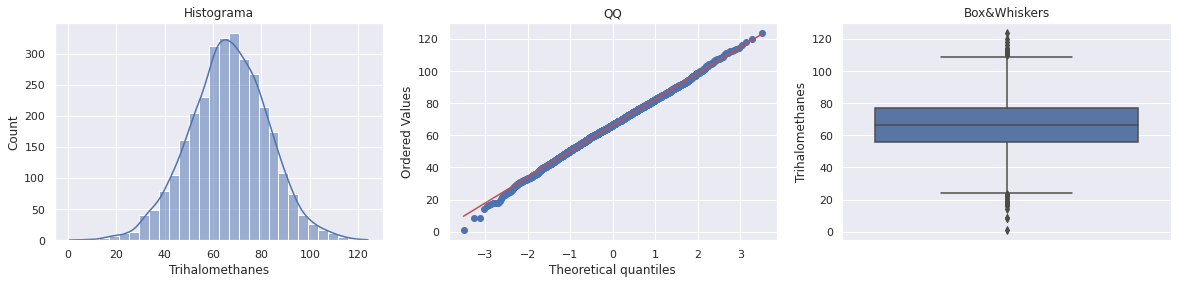

In [ ]:
outlier_diagnostic_plots(water_data, 'Trihalomethanes')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Trihalomethanes')
upper_boundary, lower_boundary

(114.92131821342397, 17.871267680112084)

##### 8.1- Analisis para potability=0

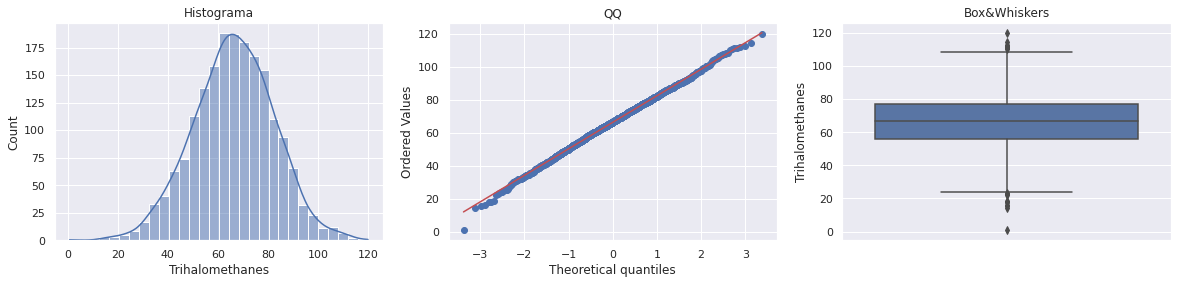

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Trihalomethanes')

##### 8.2- Analisis para potability=1

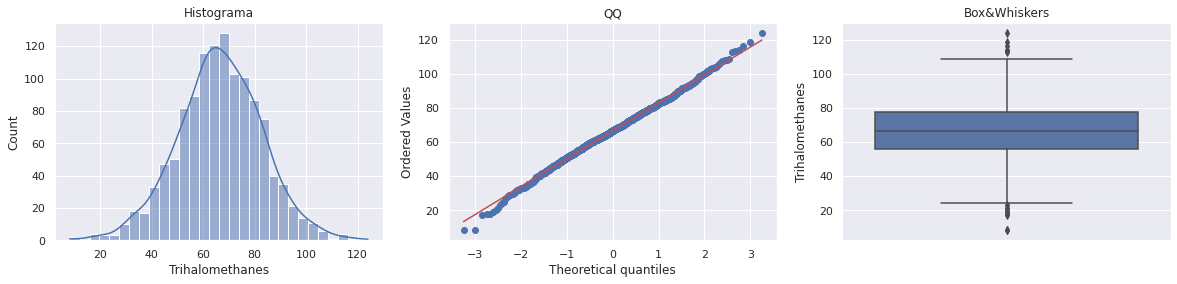

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Trihalomethanes')

#### 9- Analisis feature Turbidity

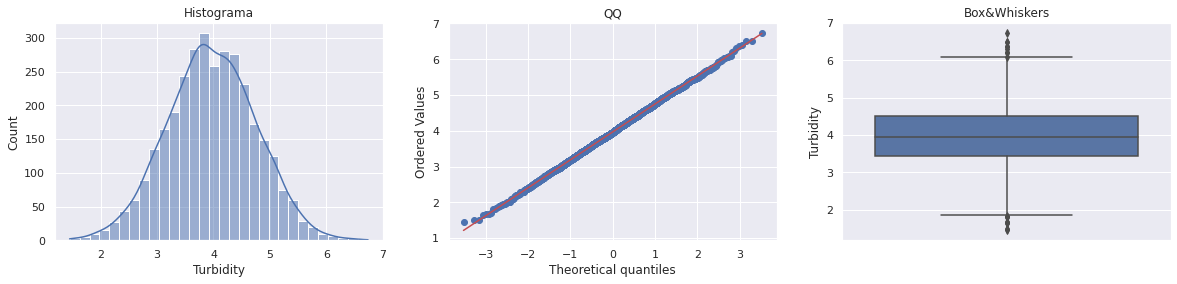

In [ ]:
outlier_diagnostic_plots(water_data, 'Turbidity')

In [ ]:
upper_boundary, lower_boundary = find_normal_boundaries(water_data, 'Turbidity')
upper_boundary, lower_boundary

(6.307933395247293, 1.6256389443348227)

##### 9.1- Analisis para potability=0

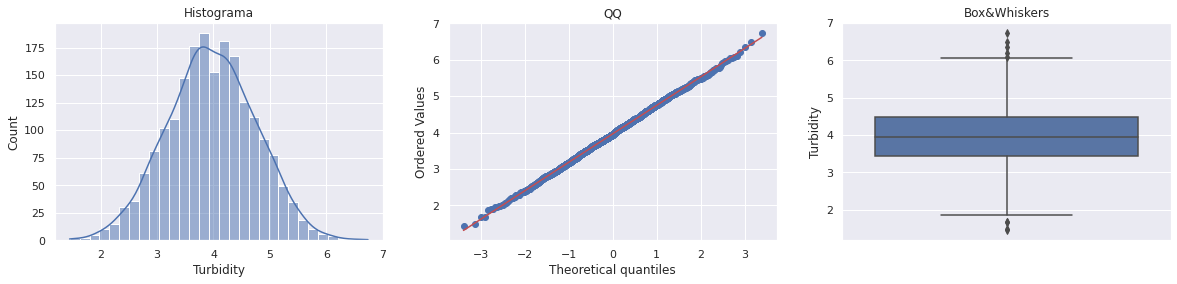

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==0], 'Turbidity')

##### 9.2- Analisis para potability=1

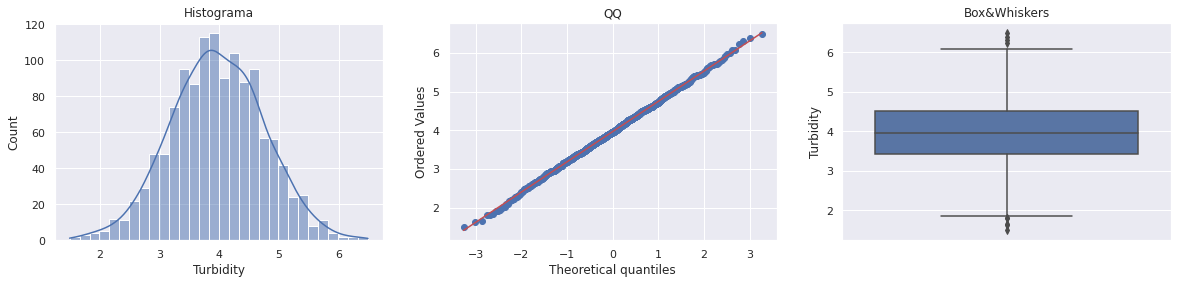

In [ ]:
outlier_diagnostic_plots(water_data[water_data.Potability==1], 'Turbidity')

### Análisis de nuestra variable a precedir (Potability)

#### Análisis de balanceo de clases 

Se observa como las clases están desbalanceadas en un 60% de agua no potable y un 40% de agua potable aproximadamente.

In [ ]:
water_count=water_data['Potability'].value_counts(normalize=True)
water_count

0    0.60989
1    0.39011
Name: Potability, dtype: float64

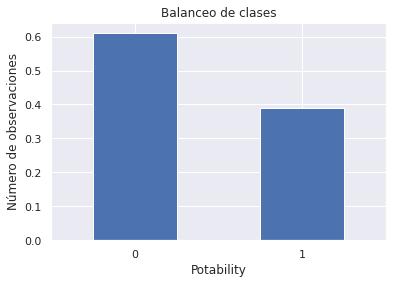

In [ ]:
water_count.plot(kind ='bar', rot=0)
plt.xticks(range(2), np.unique(water_data['Potability']))
plt.title("Balanceo de clases")
plt.xlabel("Potability")
plt.ylabel("Número de observaciones");
plt.show()

#### Distribucion de cada columna contra los valores posibles de potabilidad

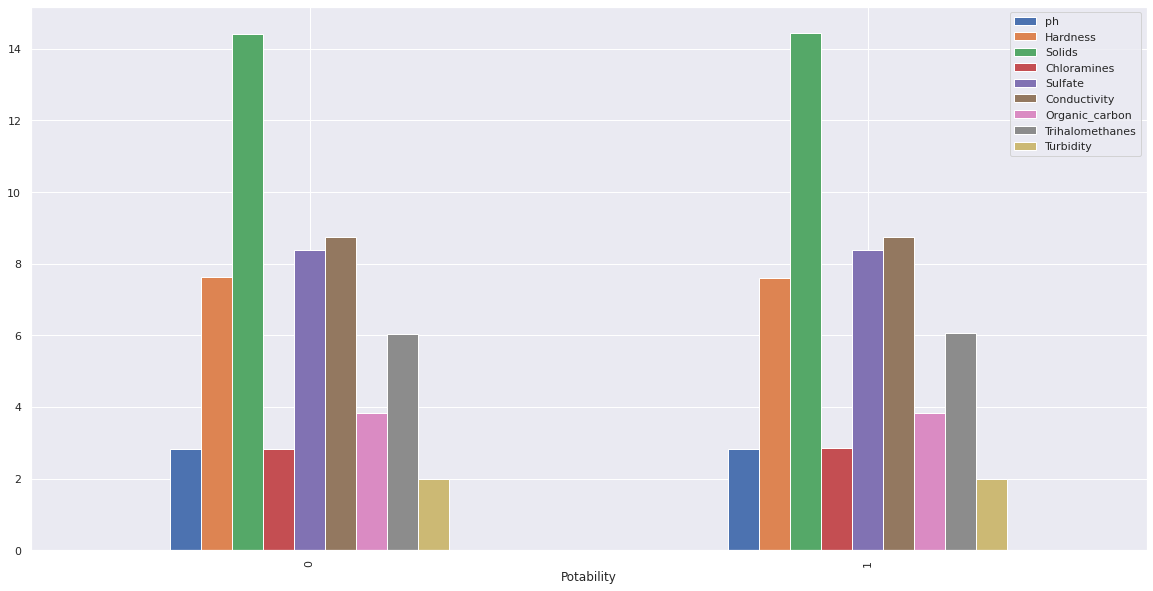

In [ ]:
#Ploteamos en escala logaritmica para ver todos los features juntos
medias_cols_potability = water_data.groupby('Potability').mean()
np.log2(medias_cols_potability).plot(kind="bar",figsize=(20,10))

Gráficamente se ve que las medias de las features son similares para los casos de agua potable y no potable, no se ven diferencias significativas. Esta situación dificulta el aprendizaje del modelo, por la dificultad de detectar diferencias que destaquen una caraterística de otra.

### Análisis de correlacion de los datos

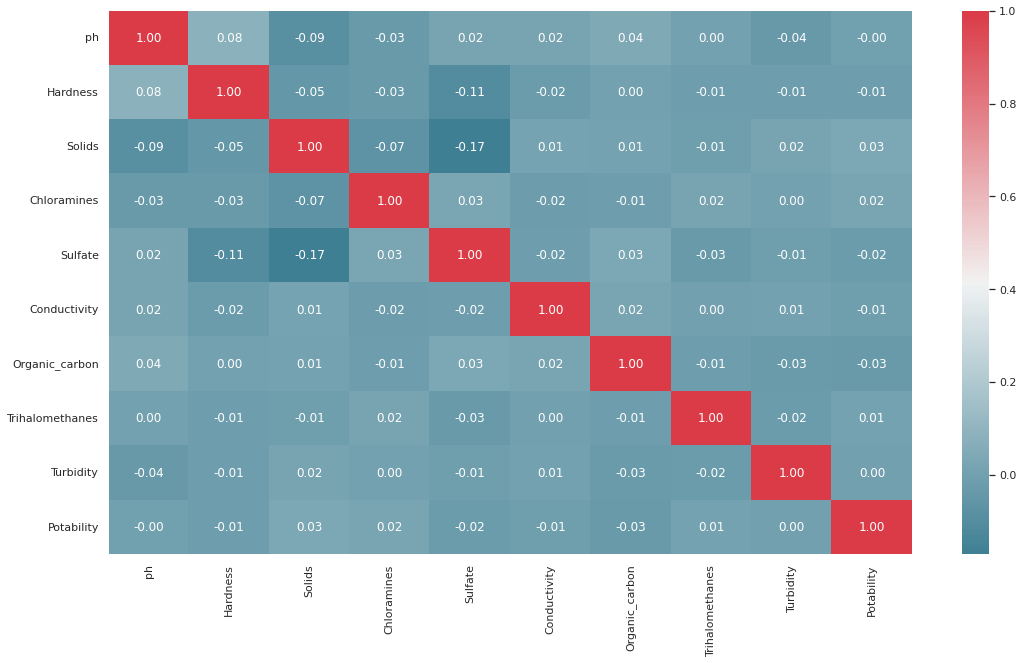

In [ ]:
corr = water_data.corr()
fig, ax1 = plt.subplots(1, figsize=(18, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=1.5)

No hay características correlacionadas, como se puede observar fuera de la diagonal los valores son cercanos a cero.

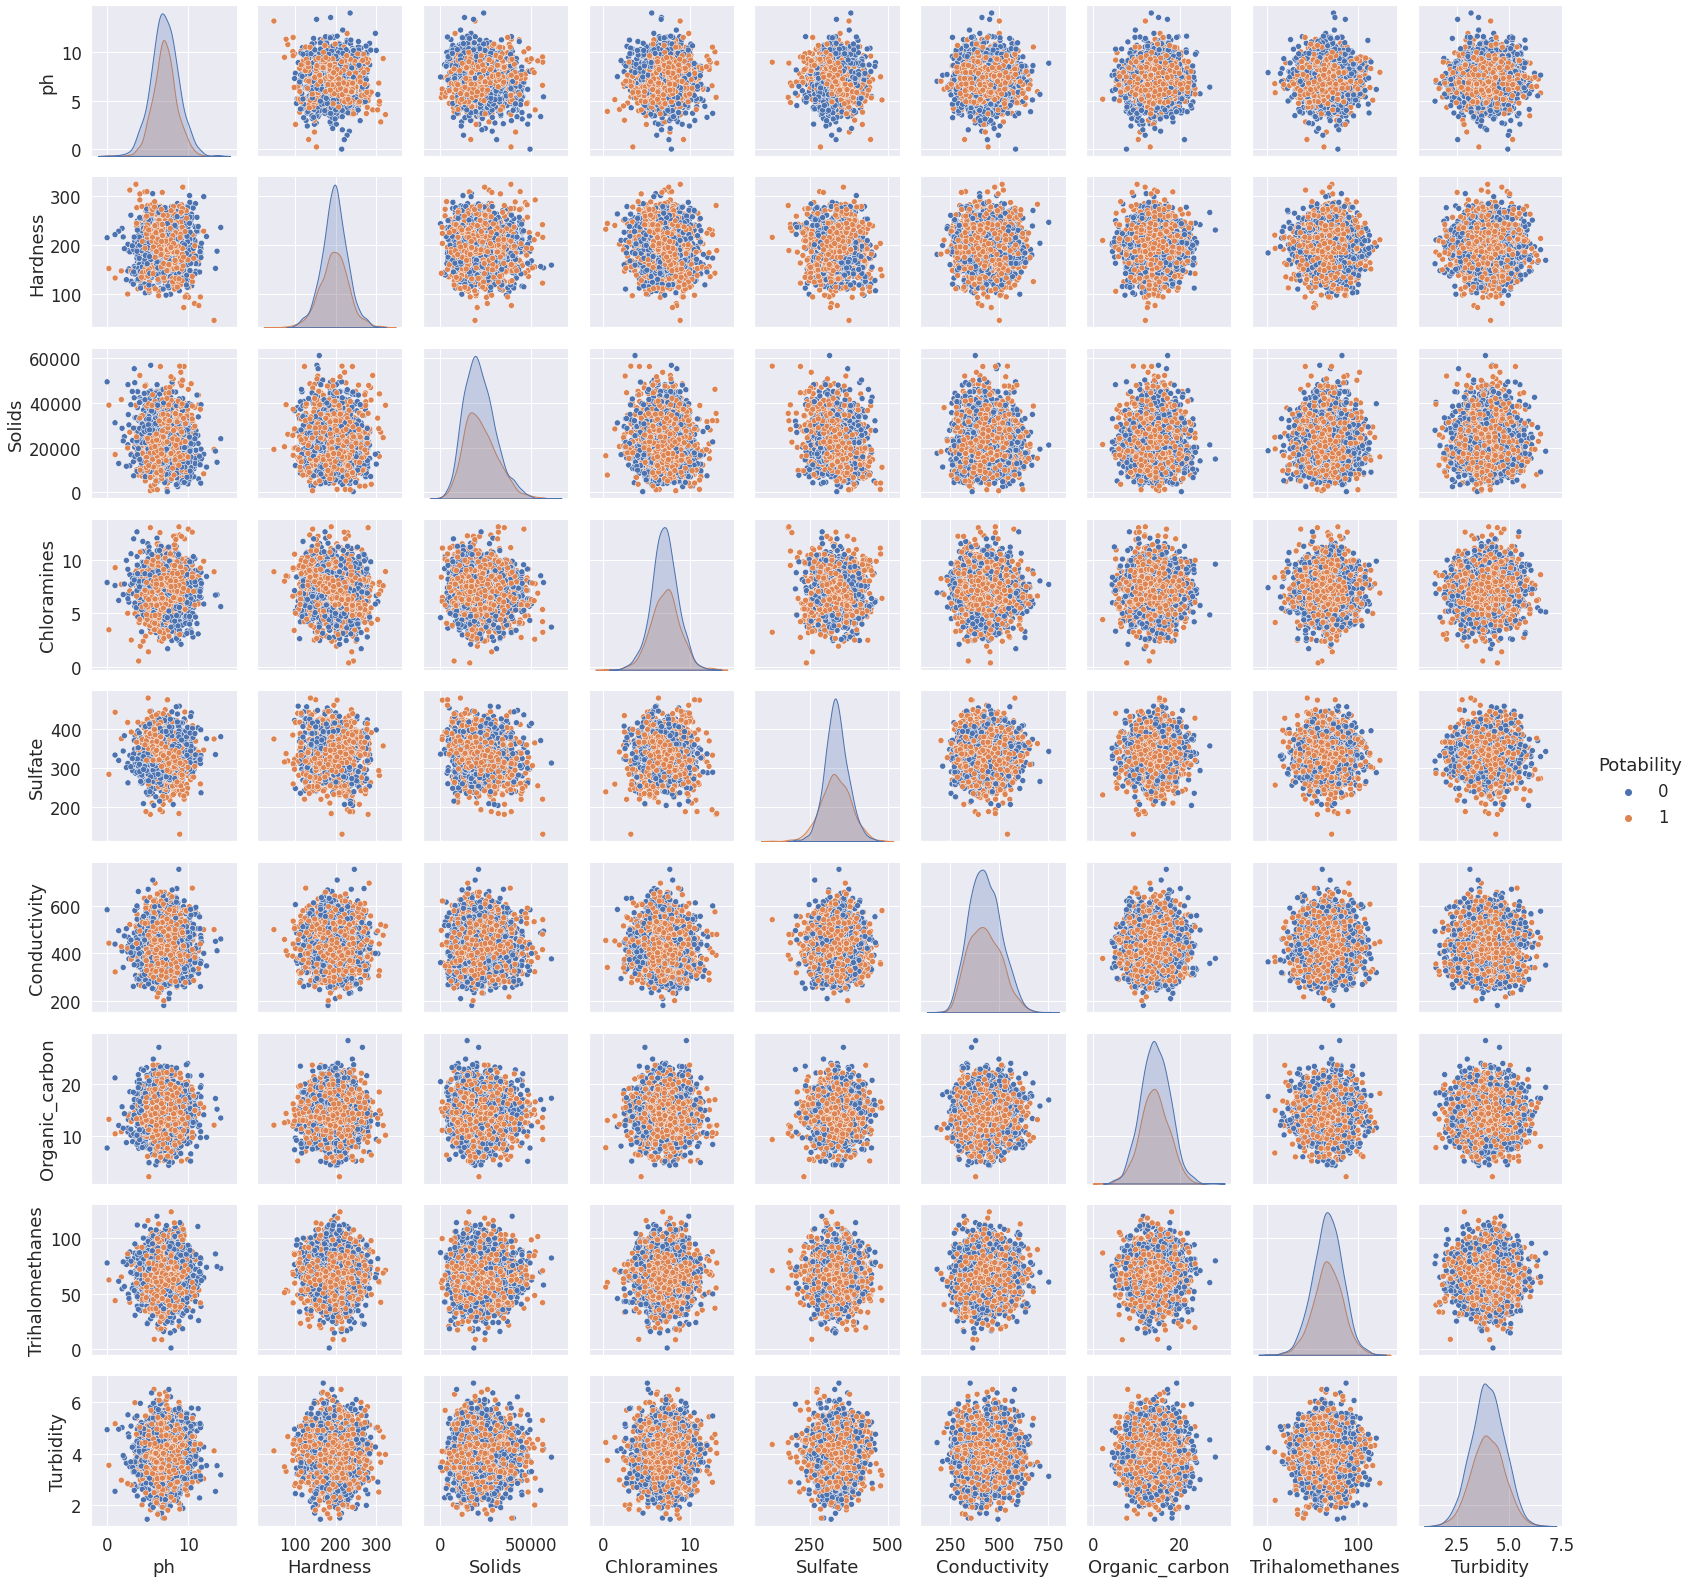

In [ ]:
### Pairplot de los datos por potabilidad
sns.pairplot(water_data, hue = 'Potability', diag_kind = 'kde')